In [ ]:
!pip install -U -q git+https://github.com/albumentations-team/albumentations


https://www.kaggle.com/reighns/augmentations-data-cleaning-and-bounding-boxes

In [ ]:
import os
import re
import cv2
import time
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid 
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from glob import glob
import seaborn as sns

%matplotlib inline

DIR = '/content/gdrive/My Drive/Global Wheat Detection/'
DIR_TRAIN = DIR + "train"
DIR_TEST = DIR + "test"
CHECKPOINT_DIR_PATH = '/content/gdrive/My Drive/Colab Notebooks/checkpoints/'
# sns.set(color_codes=True)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load data (raw data)

In [ ]:
### Loading Dataset
df = pd.read_csv(DIR + "train.csv")
df.head()
print(len(df.image_id.unique()))

3373


# Exploring Dataset

In [ ]:
sources = df["source"].unique()
print("Total Sources: ",len(sources))
print("\n> Sources <\n",sources)

Total Sources:  7

> Sources <
 ['usask_1' 'arvalis_1' 'inrae_1' 'ethz_1' 'arvalis_3' 'rres_1' 'arvalis_2']


# Null check:

In [ ]:
null_values = df.isnull().sum(axis = 0)
print("\n> Null Values in each column <")
print(null_values)


> Null Values in each column <
image_id    0
width       0
height      0
bbox        0
source      0
dtype: int64


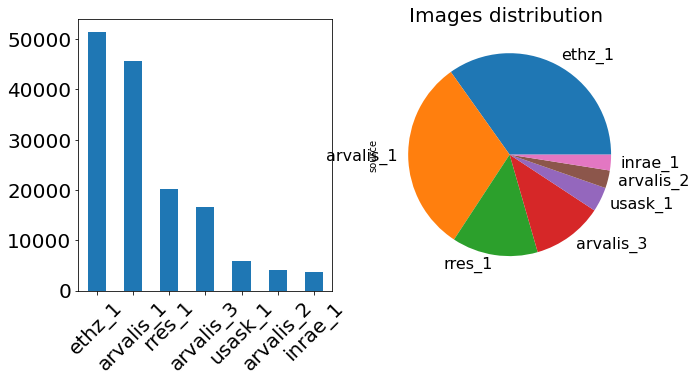

In [ ]:
new_df = df[['image_id', 'source']]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
new_df['source'].value_counts().plot(kind='bar', rot=45, fontsize=20);
plt.subplot(1, 2, 2)
new_df['source'].value_counts().plot(kind='pie', fontsize=16);

plt.title('Images distribution ', fontsize=20)
plt.yticks(rotation=45)
plt.show()


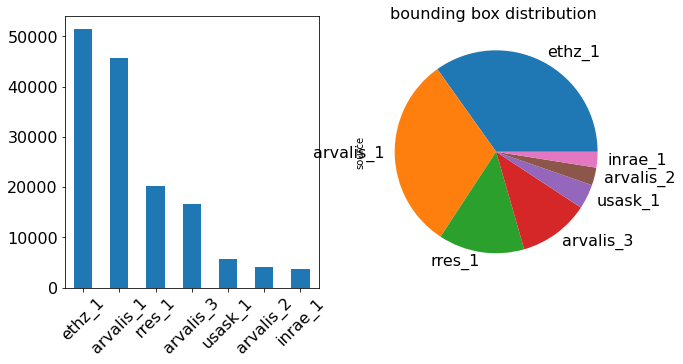

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['source'].value_counts().plot(kind='bar', rot=45, fontsize=16);
plt.subplot(1, 2, 2)
df['source'].value_counts().plot(kind='pie', fontsize=16);

plt.title('bounding box distribution ', fontsize=16)
plt.show()



In [ ]:
def plot_img(image_name, area=None, add_source=False):
    if area:
        fig, ax = plt.subplots(1, 3, figsize = (15, 15))
    else:
        fig, ax = plt.subplots(1, 2, figsize = (10, 10))
    ax = ax.flatten()
    
    records = df[df['image_id'] == image_name]
    title = 'Original Image'
    if add_source:
        source = records['source'].unique()[0]
        title = f'image source: {source} \nOriginal Image'

    img_path = os.path.join(DIR_TRAIN, image_name + ".jpg")
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image.copy()
    image3 = image.copy()
    
    ax[0].set_title(f'{title} - {image_name}.jpg', fontsize=18)
    ax[0].imshow(image)
    ax[0].set_axis_off()

    for idx, row in records.iterrows():
        box = row[['x_start', 'y_start', 'x_end', 'y_end','area']].values
        xmin = box[0]
        ymin = box[1]
        xmax = box[2]
        ymax = box[3]
        box_area = int(box[4])
        
        cv2.rectangle(image2, (int(xmin),int(ymin)), (int(xmax),int(ymax)), (1,0,0), 3)
        if area:
            if box_area == area:
                cv2.rectangle(image3, (int(xmin),int(ymin)), (int(xmax),int(ymax)), (1,0,0), 3)
                ax[2].set_title('Image with are Bondary Box', fontsize=18)
                ax[2].imshow(image3)
                ax[2].set_axis_off()

                   
    ax[1].set_title('Image with all Bondary Box', fontsize=18)
    ax[1].imshow(image2)
    ax[1].set_axis_off()

    plt.show()

# Preparing Dataset for Training 

## Changing bounding boxes from [x_min, y_min, width, height] to [x_min, y_min, x_max, y_max]

We have to make our data in a format that resnet accepts, and that's what we are doing below:

In [ ]:

### Converting bbox list in appropriate form
df = pd.read_csv(DIR + "train.csv")

df['x'] = -1
df['y'] = -1
df['w'] = -1
df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

df[['x', 'y', 'w', 'h']] = np.stack(df['bbox'].apply(lambda x: expand_bbox(x)))
df.drop(columns=['bbox'], inplace=True)
df['x'] = df['x'].astype(np.float)
df['y'] = df['y'].astype(np.float)
df['w'] = df['w'].astype(np.float)
df['h'] = df['h'].astype(np.float)

df['x_start'] = df['x'].values
df['y_start'] = df['y'].values
df['x_end'] = df['x'].values + df['w'].values
df['y_end'] = df['y'].values + df['h'].values
df['area'] = df['w'].values * df['h'].values
df = df.drop(['x', 'y', 'w', 'h'], axis=1)

df.to_csv('/content/gdrive/My Drive/Global Wheat Detection/train_pascall_voc_format.csv', index=False)
df.head()

image_id  width  height   source  x_start  y_start  x_end  y_end     area
0  b6ab77fd7   1024    1024  usask_1    834.0    222.0  890.0  258.0   2016.0
1  b6ab77fd7   1024    1024  usask_1    226.0    548.0  356.0  606.0   7540.0
2  b6ab77fd7   1024    1024  usask_1    377.0    504.0  451.0  664.0  11840.0
3  b6ab77fd7   1024    1024  usask_1    834.0     95.0  943.0  202.0  11663.0
4  b6ab77fd7   1024    1024  usask_1     26.0    144.0  150.0  261.0  14508.0

# Now lets see the images!
 we choose to plot 1 image for each source

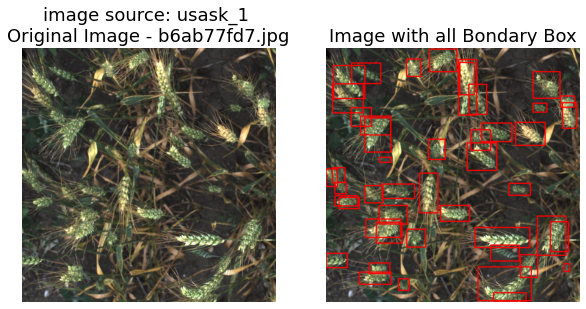

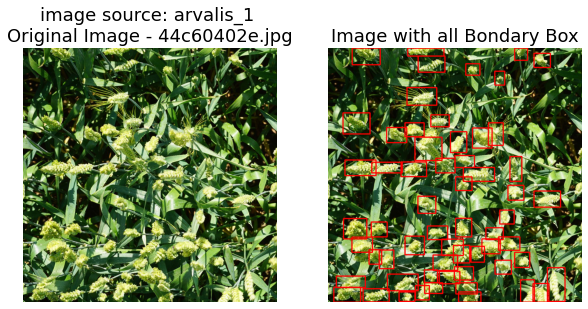

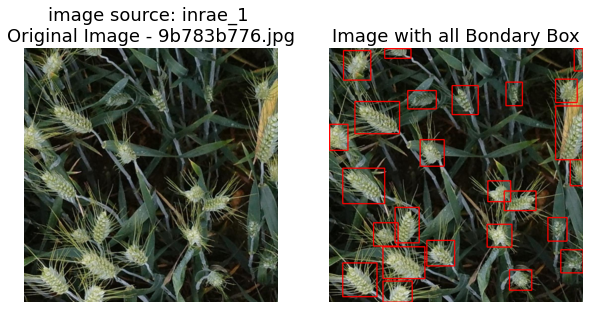

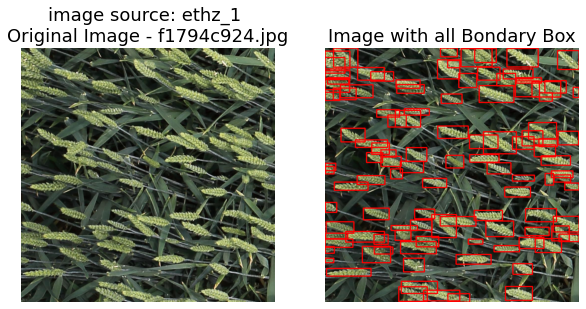

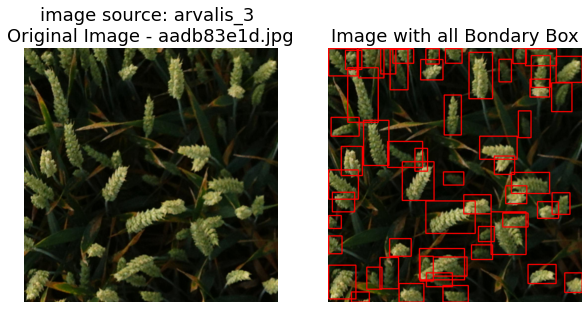

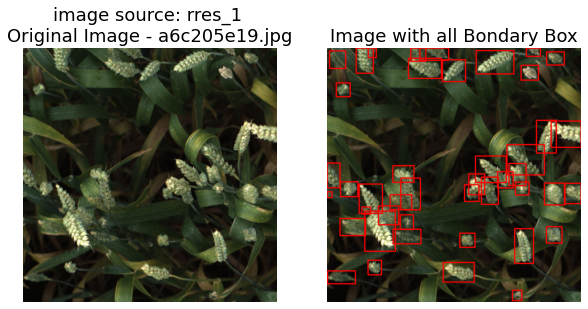

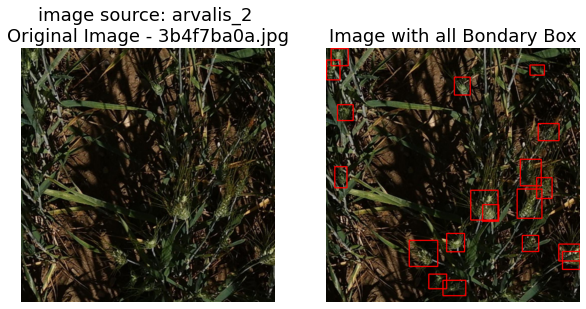

In [ ]:
sources = df.source.unique()
for source in sources:
    image = df[df['source'] == source][:1]['image_id'].values[0]
    plot_img(image, add_source=True)


In [ ]:
def show_stat(df):
    total = len(df['image_id'].unique())
    total_bbox = len(df['image_id'])
    Max = df.area.max()
    Min = df.area.min()
    mean = df.area.mean()
    std = df.area.std()

    under_x = len(df[df["x_start"] < 0])
    under_y = len(df[df["y_start"] < 0])
    upper_x = len(df[df["x_end"] > 1024])
    upper_y = len(df[df["y_end"] > 1024])

    summary = f"Details of the Wheat heads dataset:\nTotal number of images {total} with total number of {total_bbox} bounding boxes.\n"
    summary += f"X axis: There are {under_x} values that expand less then 0 and {upper_x} value rhat expand above 1024.\n" 
    summary += f"Y axis: There are {under_y} values that expand less then 0 and {upper_y} value rhat expand above 1024.\n" 
    summary += f"Statics:\nThe lagest bounding box area is: {Max} \nThe min area is: {Min}.\n" 
    summary += f"The average value of a bounding box: {mean} with standard deviation of {std}."
    print(summary)

show_stat(df)

Details of the Wheat heads dataset:
Total number of images 3373 with total number of 147793 bounding boxes.
X axis: There are 0 values that expand less then 0 and 0 value rhat expand above 1024.
Y axis: There are 0 values that expand less then 0 and 0 value rhat expand above 1024.
Statics:
The lagest bounding box area is: 529788.0 
The min area is: 2.0.
The average value of a bounding box: 6843.35657608953 with standard deviation of 5876.326590253734.


In [ ]:
from pprint import pprint
Max = df.area.max()
Min = df.area.min()
bar = np.linspace(Min, Max, 100).astype(np.int32)

d={
    key: [0, []]
    for key in bar
}
for r in range(len(df)):
    index = 0
    stop=False
    single_row = df.loc[r]
    single_area = int(single_row['area'])
    while index < (len(bar)-1):
        if single_area >= bar[index] and single_area < bar[index+1]:
            d[bar[index]][0]+=1 
            d[bar[index]][1].append([single_row['image_id'], single_area])
        index += 1

        if index == (len(df)-1):
            stop=True

    if stop:
        d[bar[index]][0]+=1 
        d[bar[index]][1].append([single_row['image_id'], single_area])    



In [ ]:
print('Bounding boxes area size distribution')
for i, (key, value) in enumerate(d.items()):
    if len(d[key][1]) != 0:
        # pprint(d[key])
        pprint(f'{bar[i]} - {bar[i+1]-1}: {d[key][0]} bounding boxes')

Bounding boxes area size distribution
'2 - 5352: 71337 bounding boxes'
'5353 - 10703: 55524 bounding boxes'
'10704 - 16055: 13466 bounding boxes'
'16056 - 21406: 4197 bounding boxes'
'21407 - 26757: 1670 bounding boxes'
'26758 - 32109: 715 bounding boxes'
'32110 - 37460: 381 bounding boxes'
'37461 - 42811: 178 bounding boxes'
'42812 - 48163: 117 bounding boxes'
'48164 - 53514: 57 bounding boxes'
'53515 - 58866: 47 bounding boxes'
'58867 - 64217: 16 bounding boxes'
'64218 - 69568: 24 bounding boxes'
'69569 - 74920: 12 bounding boxes'
'74921 - 80271: 12 bounding boxes'
'80272 - 85622: 10 bounding boxes'
'85623 - 90974: 1 bounding boxes'
'90975 - 96325: 3 bounding boxes'
'96326 - 101677: 4 bounding boxes'
'101678 - 107028: 2 bounding boxes'
'107029 - 112379: 1 bounding boxes'
'112380 - 117731: 2 bounding boxes'
'117732 - 123082: 2 bounding boxes'
'123083 - 128433: 2 bounding boxes'
'128434 - 133785: 1 bounding boxes'
'139137 - 144488: 1 bounding boxes'
'144489 - 149839: 3 bounding boxes'


# There are three posible reasons for a getting large bounding box area

## 1) bad labling - as we can see that all of the other boundning boxes inside the area are labeled. we can just remove the bad label from the dataset.

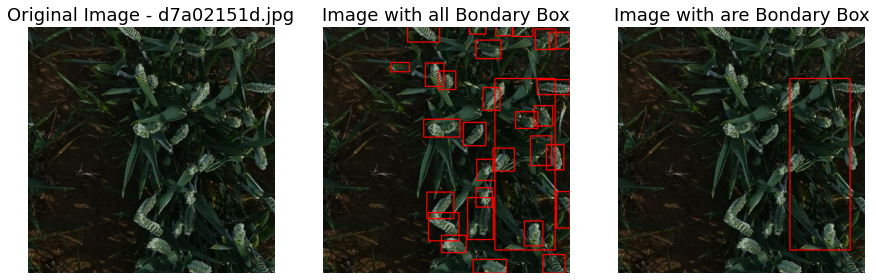

In [ ]:
plot_img('d7a02151d', area=177750)

# 2) large bounding box for several wheat heads inside it. those kind of images we have to remove from the dataset. it will harm the training.
as suggest in https://www.kaggle.com/jsaguiar/fixed-wheat-bounding-boxes, it can be replace the poor labling with accurate accurate bounding box. For our training model we choosed to ignore those images permanently.

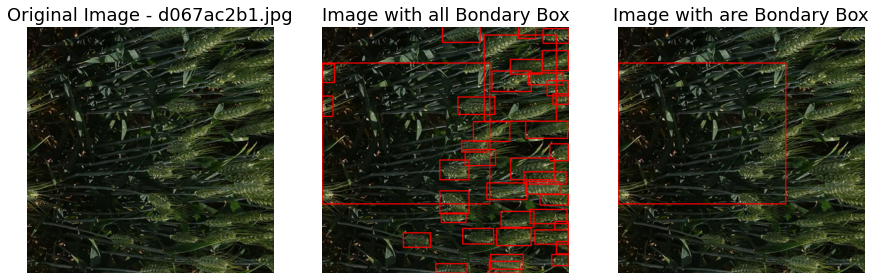

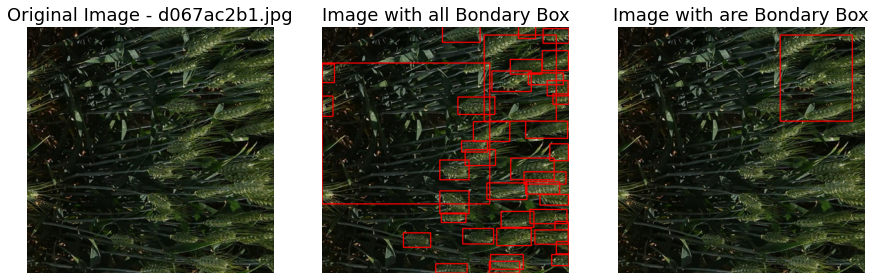

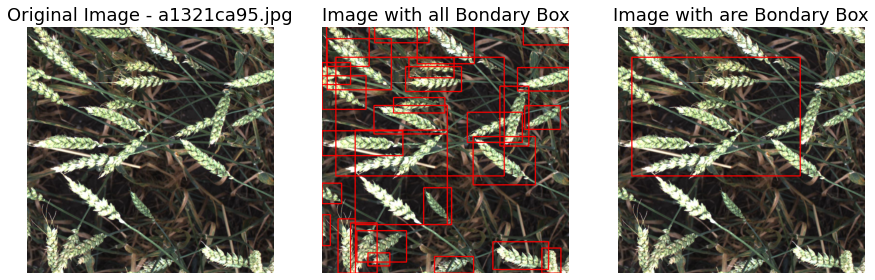

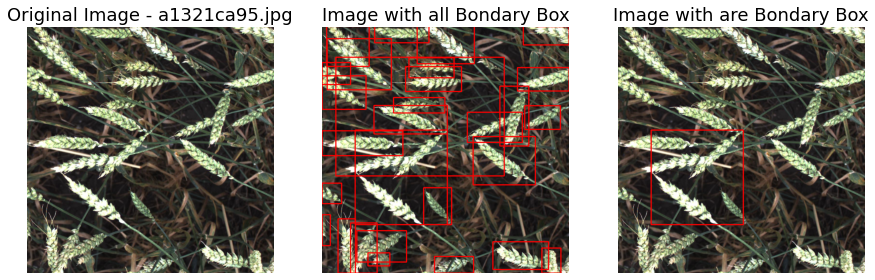

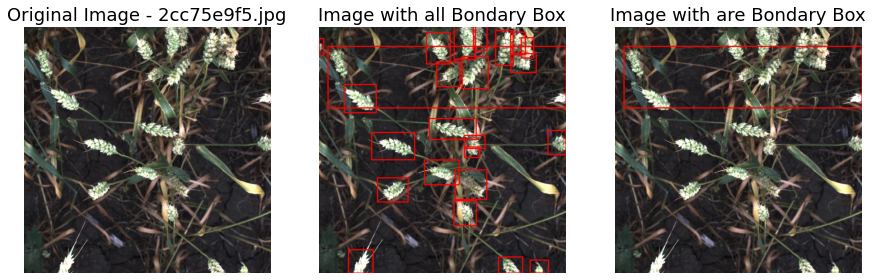

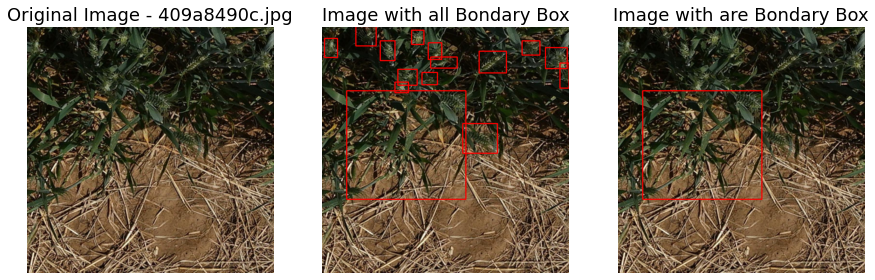

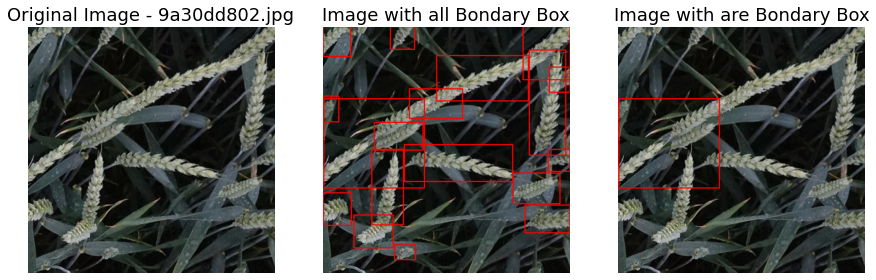

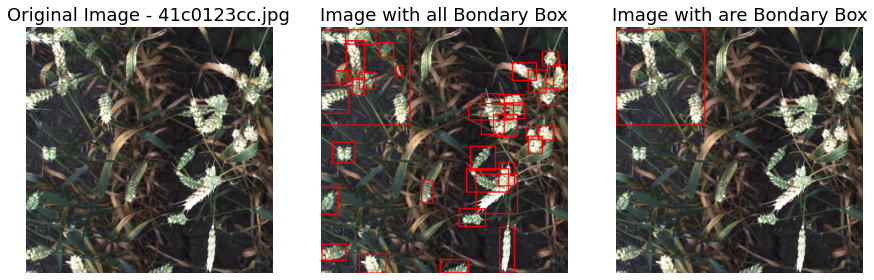

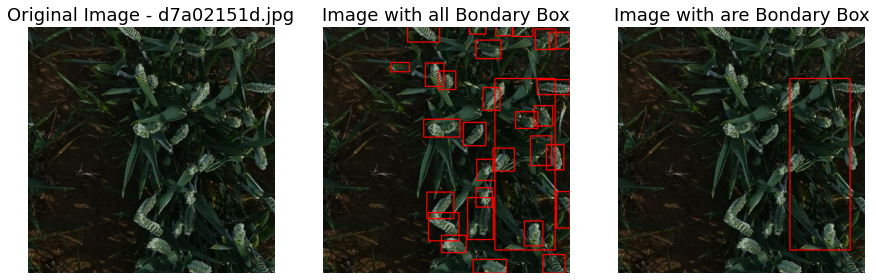

In [ ]:
plot_img('d067ac2b1', 405880)
plot_img('d067ac2b1', 106743)
plot_img('a1321ca95', 343416)
plot_img('a1321ca95', 149744)
plot_img('2cc75e9f5', 251685)
plot_img('409a8490c', 222300)
plot_img('9a30dd802', 154290)
plot_img('41c0123cc', 145360)
plot_img('d7a02151d', 177750)


# 3) Large is NOT always bad !!:)

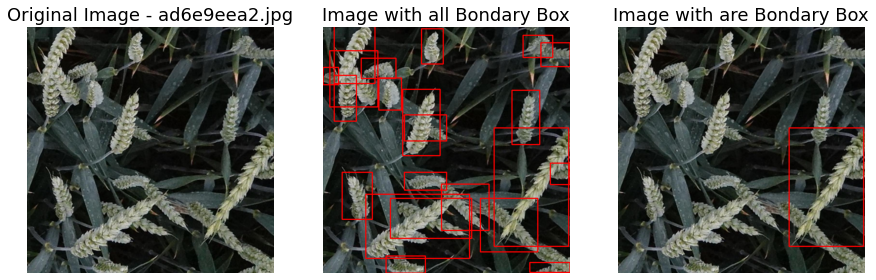

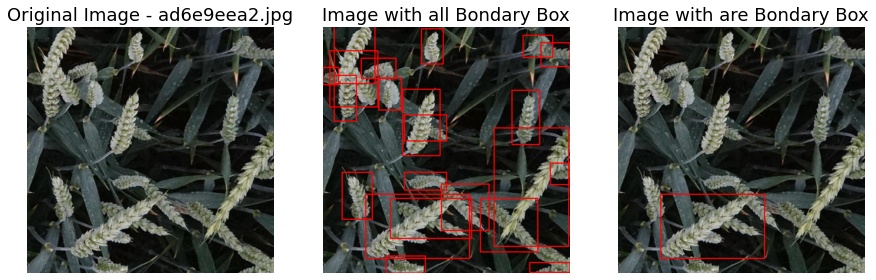

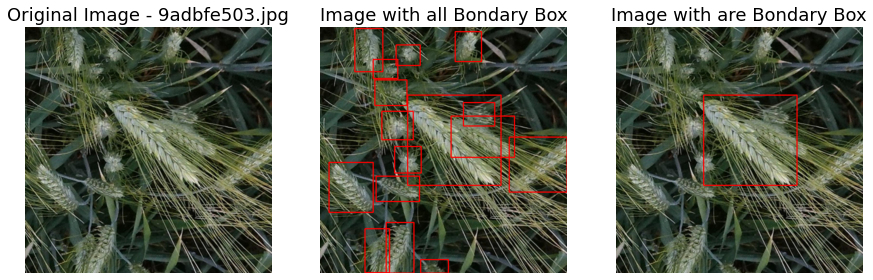

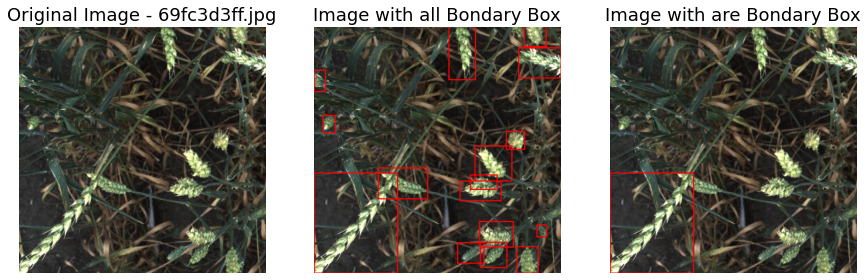

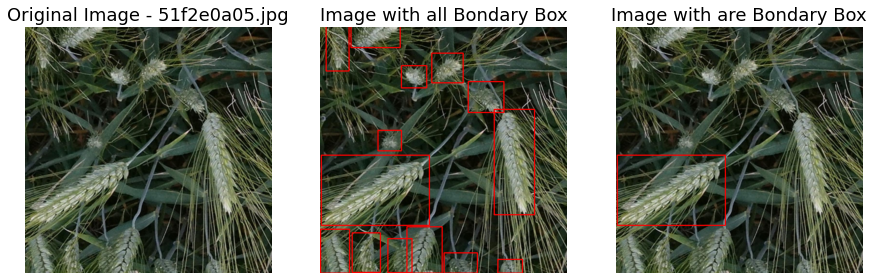

In [108]:
plot_img('ad6e9eea2', 151719)
plot_img('ad6e9eea2', 114380)
plot_img('9adbfe503', 144738)
plot_img('69fc3d3ff', 143590)
plot_img('51f2e0a05', 130368)
# plot_img('f1a8585e0', 125660)
# plot_img('7fc9fe138', 119021)
# plot_img('dcafcae79', 119790)
# plot_img('e0a241bd5', 116865)
# plot_img('b2efe29e7', 111040)
# plot_img('22eabfde5', 104907)


In [ ]:
df = df[df.area != 177750] #remove only the bounding box

remove_ids = ['d067ac2b1', 'a1321ca95', '2cc75e9f5', '409a8490c', '9a30dd802', '41c0123cc', 'd7a02151d'] #don't train on this images
df = df[~df.image_id.isin(remove_ids)]
total = len(df.image_id.unique())
total_bbox = len(df.image_id)
summary = f"Details of the Wheat heads dataset:\nTotal number of images {total} with total number of {total_bbox} bounding boxes."
print(summary)

Details of the Wheat heads dataset:
Total number of images 3366 with total number of 147603 bounding boxes.


# split the dataset into stratified 5 Fold
[k-fold-cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/)

As we can see from the images distribution part, we have problem of imbalance data sources. For handle this problem we used stratified cross-validation.

**stratified cross-validation:** The splitting of data into folds may be governed by criteria such as ensuring that each fold has the same proportion of observations with a given categorical value, such as the class outcome value. This is called 
We got the motivition form reading this karnel:
 [wbf-approach-for-ensemble](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble)
  



In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = df[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = df[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number


# save
df_folds.to_csv('/content/gdrive/My Drive/Global Wheat Detection/5_fold_new.csv')
df_folds.head()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


bbox_count     source stratify_group  fold
image_id                                             
00333207f          55  arvalis_1    arvalis_1_3     1
005b0d8bb          20    usask_1      usask_1_1     3
006a994f7          25    inrae_1      inrae_1_1     1
00764ad5d          41    inrae_1      inrae_1_2     0
00b5fefed          25  arvalis_3    arvalis_3_1     3

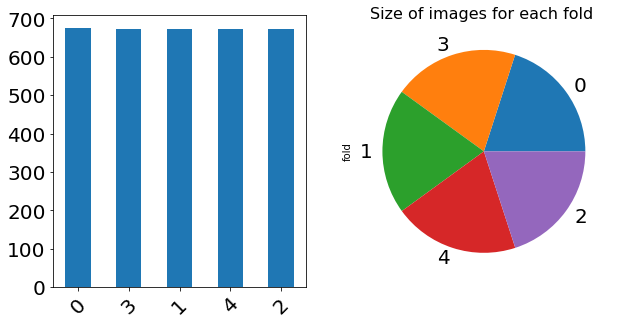

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df_folds['fold'].value_counts().plot(kind='bar', rot=45, fontsize=20);
plt.subplot(1, 2, 2)
df_folds['fold'].value_counts().plot(kind='pie', fontsize=20)

plt.title('Size of images for each fold ', fontsize=16)
plt.show()



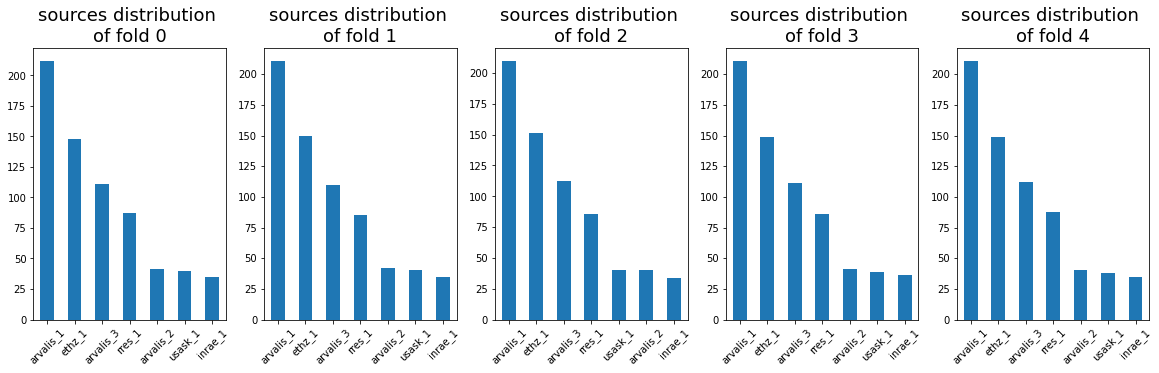

In [ ]:
folds = [0, 1, 2, 3, 4]
plt.figure(figsize=(20, 5))
for fold in folds:
    plt.subplot(1, 5, fold+1)
    temp_df = df_folds[df_folds['fold'] == fold]
    temp_df['source'].value_counts().plot(kind='bar', rot=45)
    plt.title(f'sources distribution \nof fold {fold}', fontsize=18)
plt.show()

# Apply Augmetation technique
"Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data."

for future improvment
https://www.kaggle.com/nvnnghia/awesome-augmentation

# **Blur**
WE chose to use BLUR augmentations to reduce model dependence on clear and sharp images. Using the selected augments, I can blur the images in several ways and train a more flexible model.

 **Each color augmentation hyperparameters needs to be carefully adjusted as it can destroy the images.**

* Blur - Blur the input image using a random-sized kernel.

* MotionBlur - is the apparent streaking of moving objects in an image.

* MedianBlur - Blur an image by computing median values over neighbourhoods.


# **Color**
we chose to use Color augmentations to create images with different colors to train model to recognize wheat heads from the image regardless of the color of the original image. 

 **Each color augmentation hyperparameters needs to be carefully adjusted as it can destroy the images.**

* RandomBrightness - Randomly change brightness and contrast of the input image.

* RandomContrast - Randomly change contrast of the input image.

* RandomBrightnessContrast - Randomly change brightness and contrast of the input image.

* ToGray - Convert the input RGB image to grayscale. If the mean pixel value for the resulting image is greater than 127, invert the resulting grayscale image.

* HueSaturationValue - Randomly change hue, saturation and value of the input image.


# **Weather**
There are various types of image augmentations done to increase the image corpus for training neural networks. However for training CNNs to detecting some special wheat heads conditions are required. Rain and fog also reduce the visibility to a great extent. Automold helps in addressing these challenges and augments nautre images to have various weather conditions.

https://github.com/UjjwalSaxena/Automold--Road-Augmentation-Library

* RandomShadow - Simulates shadows for the image 
* RandomRain - Adds rain effects.

# **Geometric**
Similar to blur augments, using geometric transforms allows the model to recognize facial features even if the face is not "ideal" for example: lying, smeared or tilted. The use of geometric augments will help the model identify facial features more comprehensively. It is important to pay attention to the parameters, too large a placement will destroy the image

* HorizontalFlip - Flip the input horizontally around the y-axis.
* VerticalFlip - Flip the input vertically around the x-axis.
* RandomRotate90 - Randomly rotate the input by 90 degrees zero or more times.

# **Noise**
We chose to use noise augmentations because in objects detection model training, sometimes features are not necessarily associated with awheat head. By adding noise, I can allow the model to learn the relevant features. If we add too much noise on the other hand, the picture will be destroyed.

* MultiplicativeNoise - Multiply image to random number or array of numbers.

# **Cutout**
Similar to noise augmentations, omission augmentations contribute to model training for finding the strongest features. When we omit elements from the image, we reduce the amount of features and weight the rest at higher weights. Determining the hyperparameters for omission in a careless way will reduce too many parts of the image and even the whole.

* Dropout - Augmenter that sets a certain fraction of pixels in images to zero.

* CoarseDropout - Augmenter that sets rectangular areas within images to zero.

In [ ]:
# https://github.com/UjjwalSaxena/Automold--Road-Augmentation-Library
#  https://towardsdatascience.com/automold-specialized-augmentation-library-for-autonomous-vehicles-1d085ed1f578
#  http://albumentations-demo.herokuapp.com/
from albumentations import (
    Compose, OneOf,
    # Color augmentaion:
    RandomBrightness, RandomContrast,
    RandomBrightnessContrast, ToGray, HueSaturationValue,

    # Weather augmentation:
    RandomShadow, RandomRain,

    # Geomatric transforms:
    HorizontalFlip, VerticalFlip, RandomRotate90,

    # Blur:
    Blur, MotionBlur, MedianBlur, 

    # Noise and cut:
    Cutout, 
    CoarseDropout,
    MultiplicativeNoise      
)
from albumentations.pytorch.transforms import ToTensorV2

def get_train_transform():
    return Compose([  
                    HorizontalFlip(), 
                    VerticalFlip(), 
                    RandomRotate90(),   
                    OneOf([                          
                        RandomBrightness(), 
                        RandomContrast(),
                        RandomBrightnessContrast(
                            brightness_limit= 0.2,
                            contrast_limit= 0.2),
                        ToGray(),
                        Blur(
                            blur_limit=(3, np.random.choice([5, 7, 11, 13]))), 
                        MotionBlur(
                            blur_limit=(3, np.random.choice([5, 7, 11, 13]))),
                        MedianBlur(
                            blur_limit=(3,5)),
                           HueSaturationValue(
                            hue_shift_limit = 0.2,
                            sat_shift_limit = 0.2,
                            val_shift_limit = 0.2
                        )]),

                    OneOf([
                            RandomShadow(),
                            RandomRain(rain_type=np.random.choice(['drizzle', 'heavy', 'torrential'])),
                            CoarseDropout(
                                    max_holes=30, 
                                    max_height=30, 
                                    max_width=30, 
                                    min_holes=5, 
                                    min_height=10, 
                                    min_width=10),
                            Cutout(
                                num_holes=30, 
                                max_h_size=30, 
                                max_w_size=30),
                            MultiplicativeNoise()]),
                    
                    ToTensorV2(p=1.0)
                    ],p=1., 
                    bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [ ]:
def read_image(image_id):
    image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    records = df[df['image_id'] == image_id]
    boxes = records[['x_start', 'y_start', 'x_end', 'y_end']].values
    labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
    return image, boxes, labels

def to_show(images):
    tot = len(images)
    plt.figure(figsize=[20, 20])
    for i, img in enumerate(images):
        plt.subplot(1, tot, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()


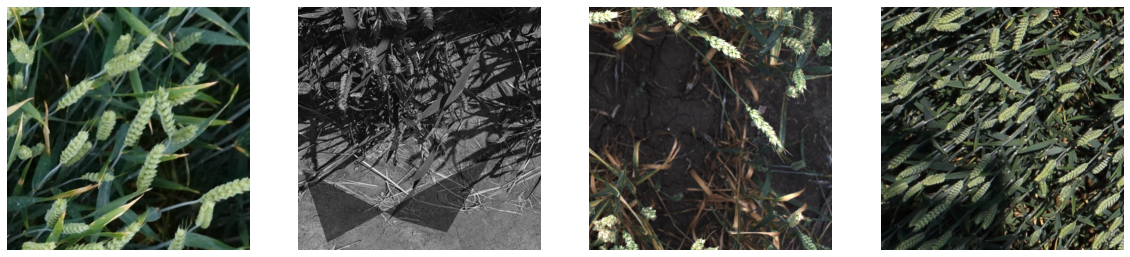

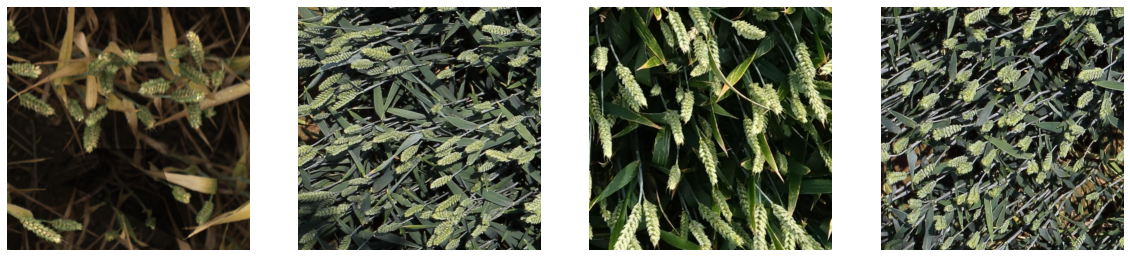

In [ ]:
def normalize(img):
    img -= img.min()
    img /= img.max()
    return img

random_images = np.random.choice(df.image_id.unique(), 8)
augmeted_images = []
for i, image_id in enumerate(random_images):
    transforms = get_train_transform()
    image, boxes, labels = read_image(image_id)
    sample = {
            'image': image,
            'bboxes': boxes,
            'labels': labels
                }
    sample = transforms(**sample)
    image = sample['image']
    image = normalize(image.permute(1,2,0).cpu().numpy())
    augmeted_images.append(image)
    if i==3 or i ==7:
        to_show(augmeted_images)
        augmeted_images = []


# A CutMix Image Generation

[CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/abs/1905.04899#:~:text=By%20making%20efficient%20use%20of,ImageNet%20weakly%2Dsupervised%20localization%20task.)

https://medium.com/depurr/cutmix-augmentation-in-python-bf099a97afac

In CutMix algorithm, for each image of batch a random region (in our case, a random bounding box region) is replaced with a patch from another training image.

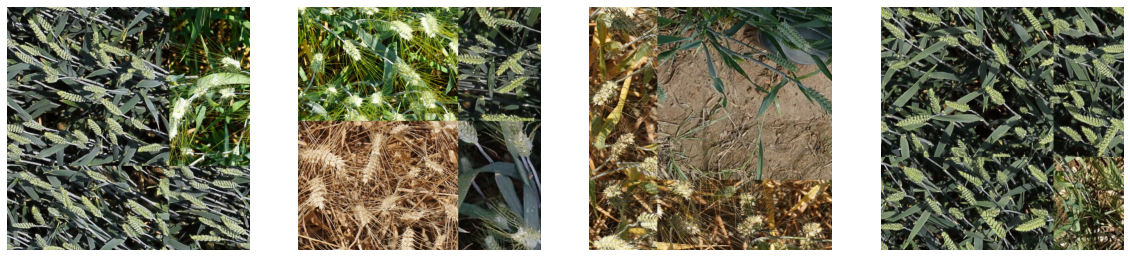

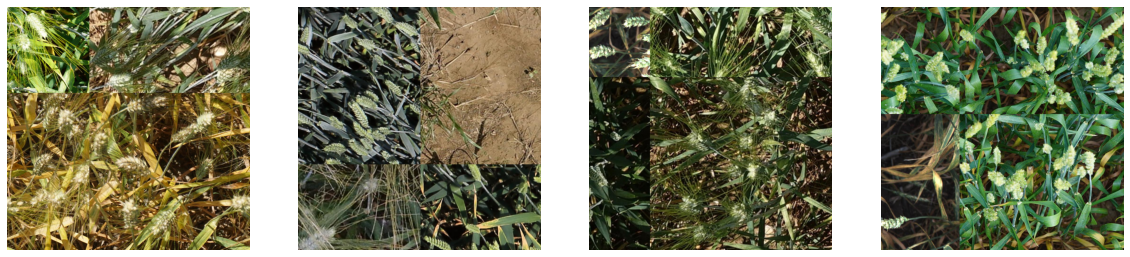

In [ ]:
def load_cutmix_image_and_boxes(image_id, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
        added_images = np.random.randint(1, 4) #images to use with cutmix
        xc, yc = [int(np.random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = np.random.choice(df.image_id.unique(), added_images).tolist()
        for _ in range(4-added_images): 
            indexes.append(image_id)
        np.random.shuffle(indexes)
        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes, _ = read_image(index)
            if i == 0: # top left
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes


random_images = np.random.choice(df.image_id.unique(), 8)
cutmix_images = []
for i, image_id in enumerate(random_images):
    image, _ = load_cutmix_image_and_boxes(image_id)
    augmeted_images.append(image)
    if i==3 or i ==7:
        to_show(augmeted_images)
        augmeted_images = []
